# Planet Satellite Imagery Workflow

## Setup

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
from osgeo import gdal
from pathlib import Path, PureWindowsPath
import matplotlib.pyplot as plt
import subprocess
import itertools
from datetime import datetime
import shutil
from collections import namedtuple

from skimage.morphology import remove_small_objects

from mintpy.utils import readfile, writefile, utils as ut
from mintpy.objects import ifgramStack
from mintpy import view

In [2]:
def read_geotiff(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    #Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent

def write_geotiff(fname, data, ds, data_type=gdal.GDT_Float32):#data_type=gdal.GDT_Float32):
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(fname, ds.RasterXSize,ds.RasterYSize, 1, data_type)
    dataset.SetGeoTransform(ds.GetGeoTransform())
    dataset.SetProjection(ds.GetProjection())
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)

    dataset = None  # Close the file
    return 


Image = namedtuple('Image','date file')

In [18]:
cd ~/pixel/poroa

/home/micromamba/pixel/poroa


In [4]:
types = {'planet':{'files':'*panchromatic_AnalyticMS_SR*tif','date_loc':slice(0,8)},
        'sentinel2':{'files':'s2*tif','date_loc':slice(-12,-4)}}

meta = types['planet']
pattern = meta['files']
date_loc = meta['date_loc']

## Image Preprocessing

In [5]:
images = [Image(os.path.basename(x)[0:8],x) for x in glob.glob('raw/*AnalyticMS_SR*tif')]
images

[Image(date='20171106', file='raw/20171106_235159_1_0f2e_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20181018', file='raw/20181018_225906_104a_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20191026', file='raw/20191026_215605_1004_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20201005', file='raw/20201005_215447_1029_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20211015', file='raw/20211015_212621_11_2212_3B_AnalyticMS_SR_clip.tif')]

In [6]:
dates = [x.date for x in images]

for d in set(dates):
    if dates.count(d) > 1:
        print(f'merging {d}...')
        files = [x.file for x in images if x.date == d]
        out_name = '_'.join(files[0].split('_')[:1]+['merged']+files[0].split('_')[-3:])
        !gdal_merge.py {' '.join(files)} -o {out_name}

In [7]:
images = [Image(os.path.basename(x)[0:8],x) for x in glob.glob('raw/*AnalyticMS_SR*tif')]

merged = [x for x in images if 'merged' in x.file]
for m in merged:
    images = [x for x in images if m.date != x.date]

images += merged
images

[Image(date='20171106', file='raw/20171106_235159_1_0f2e_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20181018', file='raw/20181018_225906_104a_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20191026', file='raw/20191026_215605_1004_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20201005', file='raw/20201005_215447_1029_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20211015', file='raw/20211015_212621_11_2212_3B_AnalyticMS_SR_clip.tif')]

In [8]:
geo = []

for n in images:
    ds = gdal.Open(n.file, gdal.GA_ReadOnly)
    data = ds.ReadAsArray()
    
    geo.append([ds.RasterXSize,ds.RasterYSize,ds.GetGeoTransform()])
    
    means = data.mean(axis=(1,2))
    stds = data.std(axis=(1,2))
    normed = (data - means[:,None,None]) / stds[:,None,None]
    pan = normed.mean(axis=0)
    
    parts = n.file.split('_')
    out_name = '_'.join([n.date]+['panchromatic']+parts[-3:])
    print(f'Writing {out_name}...')
    
    write_geotiff(out_name,pan,ds)
    ds = None

if max([len(list(set(x))) for x in zip(*geo)]) == 1:
    print('Panchromatic calculated and geotransforms the same!')
else: 
    print('Panchromatic calculated but All geotransforms the NOT same!')
    print(geo)

Writing 20171106_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20181018_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20191026_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20201005_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20211015_panchromatic_AnalyticMS_SR_clip.tif...
Panchromatic calculated and geotransforms the same!


In [9]:
images = [Image(os.path.basename(x)[0:8],x) for x in glob.glob('*panchromatic_AnalyticMS_SR*tif')]
files = [sorted(x) for x in itertools.combinations([y.file for y in images],2)]
len(files)

10

In [10]:
# if using bounds:
#for bounds, sample=x, line=y
#xstart, xend, ystart, yend
poroa_upper = '9873 10773 9570 10773'
no_bounds = ''

bounds = no_bounds
band = 1
data_dir = PureWindowsPath('I:/pixel/poroa')
out_dir = data_dir / 'cosicorr'
window = 64
step = 16

# data_dir = PureWindowsPath(data_dir)
# out_dir = PureWindowsPath(out_dir)

dic = {'primary':[f'{str(data_dir / x[0])} {band} {bounds}' for x in files],
       'secondary':[f'{str(data_dir / x[1])} {band} {bounds}' for x in files],
       'out_name':[str(out_dir / f'cosicorr_{x[0][date_loc]}T000000_{x[1][date_loc]}T000000.dat') for x in files]}

for key in dic:
    with open(f'{key}.txt', 'w') as f:
        for line in dic[key]:
            f.write(line)
            f.write('\n')

# frequency, winMaxX, winMaxY, winMinX, winMinY, stepX, stepY, nbRobustIteration, MaskThreshold, resampling, grid
options = [f'frequency {window} {window} {window} {window} {step} {step} 5 0.9 0 0'] * len(files)
with open('options.txt', 'w') as f:
    for line in options:
        f.write(line)
        f.write('\n')

In [20]:
files = glob.glob('cosicorr/*.dat')
files.sort()
files

['cosicorr/cosicorr_20171106T000000_20181018T000000.dat',
 'cosicorr/cosicorr_20171106T000000_20191026T000000.dat',
 'cosicorr/cosicorr_20171106T000000_20201005T000000.dat',
 'cosicorr/cosicorr_20171106T000000_20211015T000000.dat',
 'cosicorr/cosicorr_20181018T000000_20191026T000000.dat',
 'cosicorr/cosicorr_20181018T000000_20201005T000000.dat',
 'cosicorr/cosicorr_20181018T000000_20211015T000000.dat',
 'cosicorr/cosicorr_20191026T000000_20201005T000000.dat',
 'cosicorr/cosicorr_20191026T000000_20211015T000000.dat',
 'cosicorr/cosicorr_20201005T000000_20211015T000000.dat']

In [21]:
for f in files:
    print(f)
    for b, dataset in enumerate(['EWOffset','NSOffset','offsetSNR']):
        f_out = f'{os.path.splitext(f)[0]}_{dataset}.tif'
        ds = gdal.Open(f)
        ds = gdal.Translate(f_out, ds, bandList = [b+1])
        ds = None

cosicorr/cosicorr_20171106T000000_20181018T000000.dat
cosicorr/cosicorr_20171106T000000_20191026T000000.dat
cosicorr/cosicorr_20171106T000000_20201005T000000.dat
cosicorr/cosicorr_20171106T000000_20211015T000000.dat
cosicorr/cosicorr_20181018T000000_20191026T000000.dat
cosicorr/cosicorr_20181018T000000_20201005T000000.dat
cosicorr/cosicorr_20181018T000000_20211015T000000.dat
cosicorr/cosicorr_20191026T000000_20201005T000000.dat
cosicorr/cosicorr_20191026T000000_20211015T000000.dat
cosicorr/cosicorr_20201005T000000_20211015T000000.dat


In [22]:
# write mintpy metadata file
files = glob.glob('cosicorr/*EWOffset.tif')+glob.glob('cosicorr/*NSOffset.tif')+glob.glob('cosicorr/*offsetSNR.tif')
files.sort()
basenames = [os.path.basename(f) for f in files]
lines = [f'{f} {f[9:17]} {f[25:33]}\n' for f in basenames]
with open('cosicorr/metadata.txt', 'w') as f:
    f.writelines(lines)

## Prep data

In [14]:
mkdir cosicorr/mintpy

In [23]:
cd cosicorr/mintpy

/home/micromamba/pixel/poroa/cosicorr/mintpy


## Load Data

In [24]:
cp /home/micromamba/pixel/pixeloffset_mintpy/cosicorr.cfg ./cosicorr.cfg

In [25]:
!load_data.py -t ./cosicorr.cfg

processor : cosicorr
SAR platform/sensor : unknown from project name "None"
--------------------------------------------------
prepare metadata files for cosicorr products
prep_cosicorr.py /home/micromamba/pixel/poroa/cosicorr/*NSOffset.tif --metadata /home/micromamba/pixel/poroa/cosicorr/metadata.txt
prep_cosicorr.py /home/micromamba/pixel/poroa/cosicorr/*EWOffset.tif --metadata /home/micromamba/pixel/poroa/cosicorr/metadata.txt
prep_cosicorr.py /home/micromamba/pixel/poroa/cosicorr/*offsetSNR.tif --metadata /home/micromamba/pixel/poroa/cosicorr/metadata.txt
--------------------------------------------------
searching interferometric pairs info
input data files:
azimuthOffset   : /home/micromamba/pixel/poroa/cosicorr/*NSOffset.tif
rangeOffset     : /home/micromamba/pixel/poroa/cosicorr/*EWOffset.tif
offsetSNR       : /home/micromamba/pixel/poroa/cosicorr/*offsetSNR.tif
number of azimuthOffset   : 10
number of rangeOffset     : 10
number of offsetSNR       : 10
------------------------

## SNR Mask Generation

output file: avgSNR.h5
calculate the temporal average of offsetSNR in file inputs/ifgramStack.h5 ...
[==================================================] lines 72/72    0s /     0s
create HDF5 file: avgSNR.h5 with w mode
create dataset /offsetSNR of float32    in size of (72, 115)            with compression=None
finished writing to avgSNR.h5
time used: 00 mins 0.1 secs

view.py avgSNR.h5 --noverbose


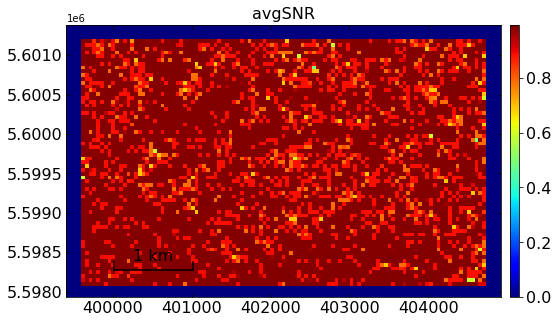

In [26]:
!temporal_average.py inputs/ifgramStack.h5 -d offsetSNR -o avgSNR.h5
view.main('avgSNR.h5 --noverbose'.split())

(0.0, 1000.0)

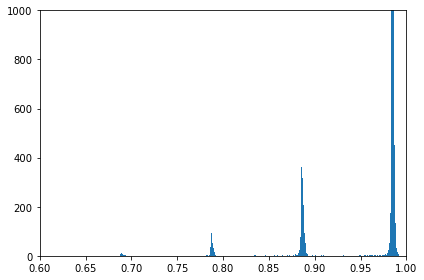

In [27]:
data, atr = readfile.read('avgSNR.h5')

fig, ax = plt.subplots(1, 1, tight_layout=True)
hist = ax.hist(data.flatten(),bins=1000)
ax.set_xlim(0.6,1)
ax.set_ylim(0.0,1000.0)

input offsetSNR file: avgSNR.h5
read avgSNR.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value < 0.7
delete exsited file: maskSNR.h5
create HDF5 file: maskSNR.h5 with w mode
create dataset /mask of bool       in size of (72, 115)            with compression=None
finished writing to maskSNR.h5
time used: 00 mins 0.1 secs.
view.py maskSNR.h5 --noverbose


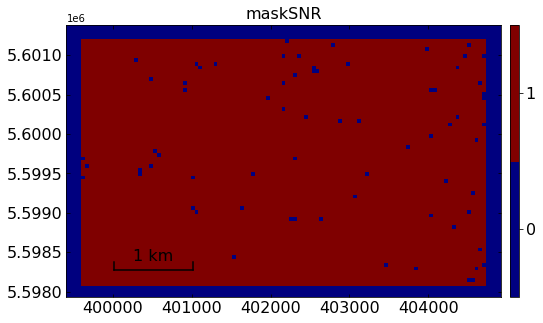

In [30]:
!generate_mask.py avgSNR.h5 -m 0.7 -o maskSNR.h5
view.main('maskSNR.h5 --noverbose'.split())

## View

view.py inputs/ifgramStack.h5 azimuthOffset --noverbose


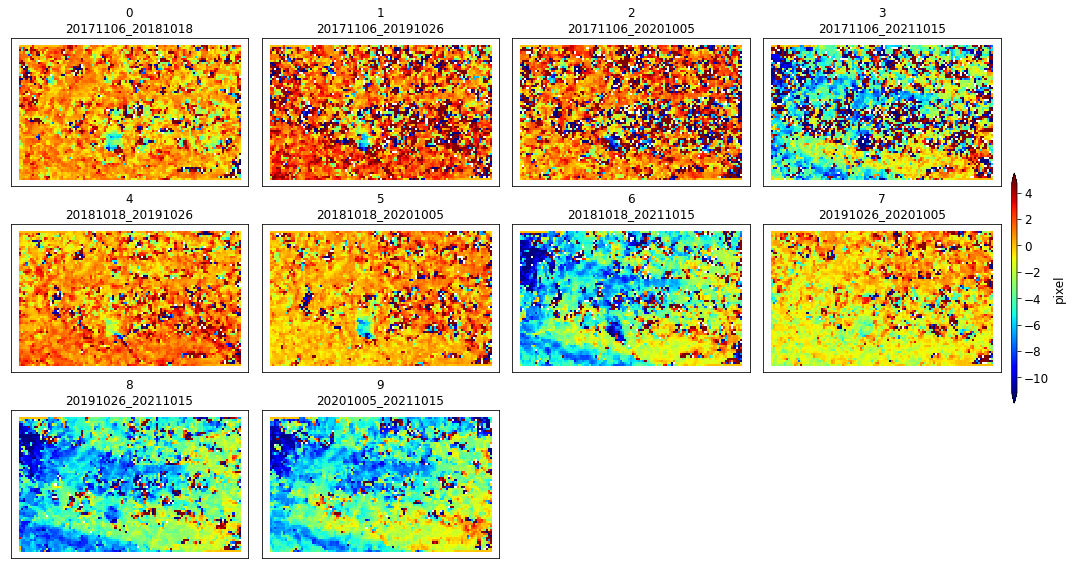

In [31]:
view.main('inputs/ifgramStack.h5 azimuthOffset --noverbose'.split())

## Inversion

In [32]:
!ifgram_inversion.py inputs/ifgramStack.h5 -i rangeOffset -w no --md offsetSNR --mt 0.9 -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5
!ifgram_inversion.py inputs/ifgramStack.h5 -i azimuthOffset -w no --md offsetSNR --mt 0.9 -o timeseriesAz.h5 residualInvAz.h5 numInvOffsetAz.h5

save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
skip checking reference pixel info - This is for offset and testing ONLY.
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
calculate STD: False 
mask out pixels with: offsetSNR < 0.9
-------------------------------------------------------------------------------
number of interferograms: 10
number of acquisitions  : 5
number of lines   : 72
number of columns : 115
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  : date       of |S8                       in size of (5,)                 with compression = None
crea

## ramp

In [33]:
!remove_ramp.py timeseriesAz.h5 -s linear -o timeseriesAz_ramp.h5 --save-ramp-coeff
!remove_ramp.py timeseriesRg.h5 -s linear -o timeseriesRg_ramp.h5 --save-ramp-coeff

remove linear ramp from file: timeseriesAz.h5
use mask of the whole area
--------------------------------------------------
grab metadata from ref_file: timeseriesAz.h5
grab dataset structure from ref_file: timeseriesAz.h5
create HDF5 file: timeseriesAz_ramp.h5 with w mode
create dataset  : bperp      of float32                   in size of (5,)                 with compression = None
create dataset  : date       of |S8                       in size of (5,)                 with compression = None
create dataset  : timeseries of float32                   in size of (5, 72, 115)         with compression = None
close  HDF5 file: timeseriesAz_ramp.h5
estimating phase ramp one date at a time ...
[==================================================] 5/5    0s /     0s
finished writing to file: timeseriesAz_ramp.h5
time used: 00 mins 0.7 secs.
add/update the following configuration metadata to file:
['mintpy.deramp', 'mintpy.deramp.maskFile']
remove linear ramp from file: timeseriesRg.h5
use m

## timeseries2velocity

In [34]:
!timeseries2velocity.py timeseriesAz.h5 -o velocityAz.h5 --bootstrap --bc 100
!timeseries2velocity.py timeseriesRg.h5 -o velocityRg.h5 --bootstrap --bc 100

bootstrapping is turned ON.
open timeseries file: timeseriesAz.h5
--------------------------------------------------
dates from input file: 5
['20171106', '20181018', '20191026', '20201005', '20211015']
--------------------------------------------------
using all dates to calculate the velocity
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    step       : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'bootstrap', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocityAz.h5 with w mode
create dataset  : velocity    of <class 'numpy.float32'>   in size of (72, 115)            with compression = None
create dataset  : velocityStd of <class 'numpy.float32'>   in size of (72, 115)            with compression = None
add /velocity    attribute: UNIT = m/ye

# Results

## Azimuth

view.py velocityAz.h5 -m maskSNR.h5 --vlim -750 750 --noverbose


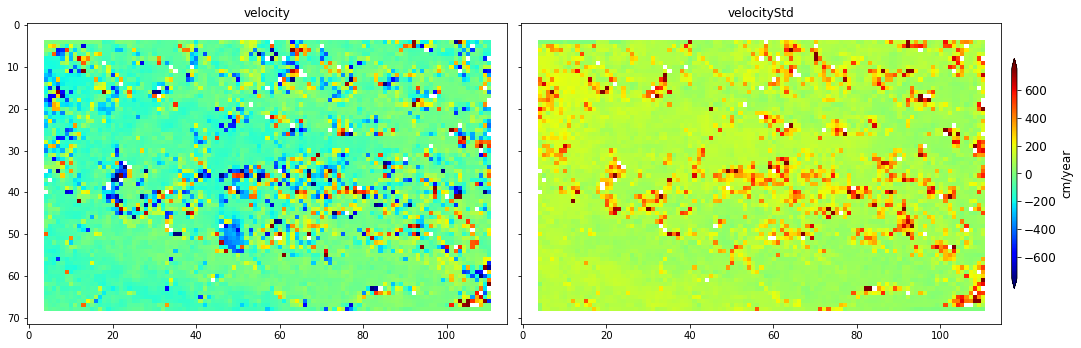

In [44]:
view.main('velocityAz.h5 -m maskSNR.h5 --vlim -750 750 --noverbose'.split())

## Range

view.py velocityRg.h5 -m maskSNR.h5 --vlim -500 500 --noverbose


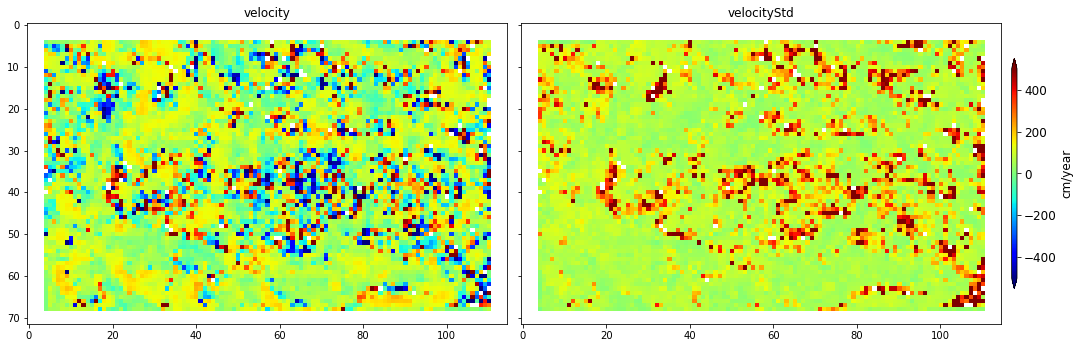

In [42]:
view.main('velocityRg.h5 -m maskSNR.h5 --vlim -500 500 --noverbose'.split())

## Magnitude

delete exsited file: velocityMg.h5
create HDF5 file: velocityMg.h5 with w mode
create dataset /velocity    of float32    in size of (114, 108)           with compression=None
create dataset /velocityStd of float32    in size of (114, 108)           with compression=None
finished writing to velocityMg.h5
view.py velocityMg.h5 --noverbose


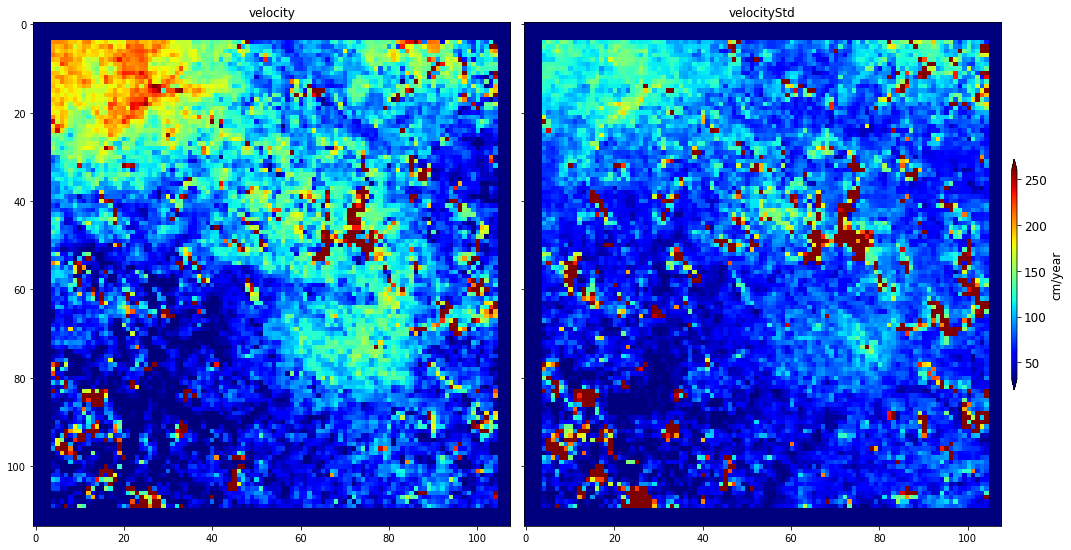

In [48]:
az, atr = readfile.read('velocityAz.h5',datasetName='velocity')
az_std, _ = readfile.read('velocityAz.h5',datasetName='velocityStd')

rg, _ = readfile.read('velocityRg.h5',datasetName='velocity')
rg_std, _ = readfile.read('velocityRg.h5',datasetName='velocityStd')

mg = np.sqrt(np.power(az,2) + np.power(rg,2))
mg_std = np.sqrt(np.power(az_std,2) + np.power(rg_std,2))

datasetDict = {'velocity':mg, 'velocityStd':mg_std}
writefile.write(datasetDict,out_file='velocityMg.h5',ref_file='velocityAz.h5')

view.main('velocityMg.h5 --noverbose'.split())

## GIF

In [389]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
from IPython.display import HTML
from skimage.exposure import match_histograms

In [395]:
images = [Image(os.path.basename(x)[0:8],x) for x in glob.glob('/mnt/i/planet/andrew/raw/*AnalyticMS_SR*tif')]

merged = [x for x in images if 'merged' in x.file]
for m in merged:
    images = [x for x in images if m.date != x.date]

images += merged
images = sorted(images)
images

[Image(date='20170911', file='/mnt/i/planet/andrew/raw/20170911_merged_AnalyticMS_SR_clip.tif'),
 Image(date='20180909', file='/mnt/i/planet/andrew/raw/20180909_merged_AnalyticMS_SR_clip.tif'),
 Image(date='20190918', file='/mnt/i/planet/andrew/raw/20190918_merged_AnalyticMS_SR_clip.tif'),
 Image(date='20200903', file='/mnt/i/planet/andrew/raw/20200903_212616_52_2212_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20210910', file='/mnt/i/planet/andrew/raw/20210910_212429_42_2439_3B_AnalyticMS_SR_clip.tif')]

In [408]:
ds = gdal.Open(images[0].file, gdal.GA_ReadOnly)
xsize = ds.RasterXSize
ysize = ds.RasterYSize
ds = None

p = [850,1050,700,900]
pans = np.zeros((len(images),p[1]-p[0],p[3]-p[2],3))

# pans = np.zeros((len(fnames),ysize,xsize))
for i,im in enumerate(images):
    for b in [1,2,3]:
        data = read_geotiff(im.file,b)[0][p[0]:p[1],p[2]:p[3]]

        low, high = data.min(),data.max()
        data_transform = (data - low) / high
        data_transform[data_transform < 0] = 0
        data_transform[data_transform > 1] = 1
        pans[i,:,:,3-b] = data_transform

In [428]:
ref = 4
pans_view = np.zeros(pans.shape)

for i in range(pans.shape[0]):
    pans_view[i] = match_histograms(pans[i],pans[ref])

In [419]:
ts, _ = readfile.read('timeseriesAz.h5')
v = [x // 15 for x in p]
ts_view = ts[:,v[0]:v[1],v[2]:v[3]]

In [434]:
matplotlib.rcParams['figure.dpi'] = 300
years = [str(x) for x in range(2017,2022)]
vrange = [-10,10]

fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[1,1.25])    
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ims = []
for i in range(ts.shape[0]):
    im1 = ax1.imshow(pans_view[i],animated=True)#,cmap='Greys_r',vmin=-3,vmax=3)
    ax1.set_axis_off()
    txt = ax1.text(0.2,0.8,years[i],horizontalalignment='center', verticalalignment='bottom',
            transform=ax1.transAxes,fontsize=16,color='white')
    im2 = ax2.imshow(ts_view[i], animated=True,vmin=vrange[0],vmax=vrange[1])
    ax2.set_axis_off()
    
    # show an initial one first
    if i == 0:
        ax1.imshow(pans_view[i],animated=True,cmap='Greys_r',vmin=-3,vmax=3)
        plt.axis('off')
        ax2.imshow(ts_view[i],animated=True,vmin=vrange[0],vmax=vrange[1])
        plt.axis('off')
        
    ims.append([im1,im2,txt])

ax1.set_title('Satellite Imagery')
ax2.set_title('Northward Motion (m)')
fig.colorbar(im2,orientation='vertical',shrink=0.5)
ani = animation.ArtistAnimation(fig, ims, blit=True,repeat=True, interval=1250,repeat_delay=1000)

plt.tight_layout()
plt.close(ani._fig)

# HTML(ani.to_html5_video())

ani.save('andrew.gif', writer='ffmpeg')
!cp andrew.gif /mnt/i/andrew.gif

## Mask

In [39]:
# vel = 'Mg'
# data, atr = readfile.read(f'velocity{vel}.h5',datasetName='velocity')
# data_std, atr = readfile.read(f'velocity{vel}.h5',datasetName='velocityStd')

# m, std = np.nanmean(data), np.nanstd(data)
# print(m,std)

# # mask = np.abs(data) > (data_std*2)
# mask = ((data > m+std) | (data < m-std))
# # mask = (np.abs(data) > (data_std*2)) & ((data > m+std*0.5) | (data < m-std*0.5))
# mask = remove_small_objects(mask,4, connectivity=2)

# data[~mask] = np.nan
# data_std[~mask] = np.nan

# writefile.write({'velocity':data,'velocityStd':data_std}, f'velocity{vel}Mask.h5', ref_file=f'velocity{vel}.h5')
# view.main(f'velocity{vel}Mask.h5 --noverbose'.split())

## Transfer Results

In [32]:
out_dir =  '/mnt/i/sentinel2/andrew/cosicorr32'
files = ['velocityAz.h5','velocityRg.h5']

for f in files:
    out_f = os.path.join(out_dir,f'{f.split(".")[0]}.tif')
    !save_gdal.py $f -d velocity -o $out_f

read metadata from file: velocityAz.h5
read data     from file: velocityAz.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 137, 130
raster transform info: (418185.0, 40.0, 0, 5508585.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/sentinel2/andrew/cosicorr32/velocityAz.tif
read metadata from file: velocityRg.h5
read data     from file: velocityRg.h5
initiate GDAL driver: GeoTIFF
create raster band
raster row / column number: 137, 130
raster transform info: (418185.0, 40.0, 0, 5508585.0, 0, -40.0)
write data to raster band
set projection as: EPSG 32760
finished writing to /mnt/i/sentinel2/andrew/cosicorr32/velocityRg.tif
